In [ ]:
!pip install stable-baselines3[extra]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.9 MB/s eta 0:00:00


In [ ]:
import random
import numpy as np
import pandas as pd
import yfinance as yf
import gymnasium as gym
import matplotlib.pyplot as plt
from datetime import datetime
from stable_baselines3 import PPO, DQN
from stable_baselines3.common.callbacks import BaseCallback

random.seed(42)
np.random.seed(42)

In [ ]:
def get_data(ticker, start_date, end_date):
    date_obj = datetime.strptime(start_date, '%Y-%m-%d')
    new_date_obj = date_obj.replace(year=date_obj.year - 1)
    calc_start = new_date_obj.strftime('%Y-%m-%d')

    data = yf.download(ticker, start=calc_start, end=end_date)
    data.drop(labels=['Adj Close','Volume'], axis=1, inplace=True)
    data = data.round(2)

    # 이동평균선
    data['SMA_5'] = data['Close'].rolling(window=5).mean()
    data['SMA_10'] = data['Close'].rolling(window=10).mean()
    data['SMA_20'] = data['Close'].rolling(window=20).mean()

    # # RSI - 14일
    # delta = data['Close'].diff()
    # gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    # loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    # rs = gain / loss
    # data['RSI'] = 100 * rs / (1 + rs)

    data = data.round(2)
    data = data[start_date:]

    return data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# 강화학습 환경
class StockTradingEnv(gym.Env):
    def __init__(self, data, gamma=0.99, split=40, initial_funds=10000, past_obs=5):
        super(StockTradingEnv, self).__init__()
        self.data = data                        # 주가 데이터
        self.avg_price = 0.0                    # 평균 단가
        self.gamma = gamma                      # 할인율 (장기 보상 강화)
        self.current_step = past_obs - 1        # 현재 단계
        self.initial_funds = initial_funds      # 초기 자금
        self.balance = self.initial_funds       # 잔고
        self.split = split                      # 분할 수
        self.once = self.balance / self.split   # 1회 구매액
        self.fee = 0.00044                      # 거래 수수료 : 비교를 위해 백테스트 시트와 동일하게 설정
        self.shares = 0                         # 보유 주식 수
        self.total_value = self.initial_funds   # 포트폴리오 가치
        self.max_value = self.initial_funds     # 최대 포트폴리오
        self.past_obs = past_obs                # 과거 n일간의 정보를 이용
        self.avg_hist = [0.0] * len(self.data)  # 평균 단가 로그
        self.penalty_rate = 0.5                 # DD에 따른 패널티 적용 비율
        self.last_value = self.initial_funds    # split 주기로 자산 계산

        # 연속 행동 공간 : 평균 단가 기준 해당 %로 주문 요청
        self.action_space = gym.spaces.Box(low=-0.1, high=0.1, shape=(1,))

        # 상태 공간 : 시가, 고가, 저가, 종가, 이평선 3종, RSI, 평균 단가
        self.observation_space = gym.spaces.Box(low=0, high=np.inf, shape=(past_obs, data.shape[1] + 1))

    def step(self, action):
        reward = 0
        buy_qty_avg = 0
        buy_qty_act = 0
        sell_qty_ten = 0
        sell_qty_act = 0
        sell_qty_quarter = 0
        buy_price_act = 0
        sell_price_ten = 0
        sell_price_act = 0
        past_avg = 0.0
        quarter_loss = False

        # current_step까지의 주가 데이터(장 마감 시 데이터)를 기준으로 다음 시장의 추천 가격 책정
        next_info = self.data.iloc[self.current_step + 1]
        next_close = self.data.iloc[self.current_step + 1]["Close"].item()
        next_high = self.data.iloc[self.current_step + 1]["High"].item()

        sell_ratio = action[0]  # 매도 가격 조정

        # 예수금 부족 시 1/4 손절하여 회복
        if self.balance < self.once:
            quarter_loss = True

            sell_qty_quarter = self.shares // 4
            sell_price_ten = next_close
            sell_amount = np.round(sell_qty_quarter * sell_price_ten * (1 - self.fee), 2)
            new_balance = self.balance + sell_amount

            self.balance = new_balance
            self.shares -= sell_qty_quarter
        else:
            # 매수 전에 매도 수량 및 가격 먼저 계산
            past_avg = self.avg_price

            sell_qty_ten_tmp = self.shares * 3 // 4
            sell_price_ten = np.round(self.avg_price * 1.1, 2)

            sell_qty_act_tmp = self.shares - sell_qty_ten_tmp
            sell_price_act = np.round(self.avg_price * (1 + sell_ratio), 2)

            # 매수 ------------------------------------------------------------------------------
            # 첫 매수 시 종가로 매수
            if self.shares == 0:
                buy_qty_avg = self.once // next_close
                self.balance -= np.round(buy_qty_avg * next_close * (1 + self.fee), 2)
                self.avg_price = next_close
                self.shares += buy_qty_avg
            # 절반은 평단, 나머지는 강화학습 추천 가격
            else:
                half_once = self.once / 2
                buy_price_act = sell_price_act - 0.01

                if next_close <= self.avg_price:
                    buy_qty_avg = half_once // next_close
                    self.balance -= np.round(buy_qty_avg * next_close * (1 + self.fee), 2)
                    self.avg_price = np.round((self.shares * self.avg_price + buy_qty_avg * next_close) / (self.shares + buy_qty_avg), 2)
                    self.shares += buy_qty_avg

                if next_close <= buy_price_act:
                    buy_qty_act = half_once // next_close
                    self.balance -= np.round(buy_qty_act * next_close * (1 + self.fee), 2)
                    self.avg_price = np.round((self.shares * self.avg_price + buy_qty_act * next_close) / (self.shares + buy_qty_act), 2)
                    self.shares += buy_qty_act

            # 매도 ------------------------------------------------------------------------------
            # 3/4는 10% 수익, 나머지는 추천 가격
            if next_high >= sell_price_ten:
                sell_qty_ten = sell_qty_ten_tmp
                sell_amount = np.round(sell_qty_ten * sell_price_ten * (1 - self.fee), 2)

                self.shares -= sell_qty_ten
                self.balance += sell_amount

            if next_close >= sell_price_act:
                sell_qty_act = sell_qty_act_tmp
                sell_amount = np.round(sell_qty_act * next_close * (1 - self.fee), 2)

                self.shares -= sell_qty_act
                self.balance += sell_amount

        # 스텝별 평균단가 로그
        self.avg_hist[self.current_step + 1] = self.avg_price

        # 포트폴리오 가치 갱신
        self.total_value = self.balance + (self.shares * next_close)

        #분할 수를 한 사이클로 잡아서 사이클 단위로 보상 및 패널티
        if self.current_step % self.split == 0 or self.current_step == len(self.data) - 1:
            reward += (self.total_value - self.last_value) / self.last_value * 100

            # MDD 관리 : DD 비율에 따른 패널티 부여
            reward -= self.penalty_rate * self.get_DD()

            self.last_value = self.total_value

        # 포트폴리오 고점 갱신
        self.max_value = max(self.max_value, self.total_value)

        # 할인율 적용 (장기 보상 중점)
        reward *= self.gamma

        # 마지막 데이터이면 에피소드 종료
        done = self.current_step >= len(self.data) - 2

        # 다음 상태로 업데이트
        if not done:
            self.current_step += 1

        # 다음 스텝의 정보
        obs = self._get_observation()

        # 다른 중단 조건은 없으므로 False
        truncated = False

        return obs, reward, done, truncated, {
            "Open": next_info['Open'].item(),
            "High": next_info['High'].item(),
            "Low": next_info['Low'].item(),
            "Close": next_info['Close'].item(),
            "Avg_Price": self.avg_price,
            "Buy_Qty_Avg": buy_qty_avg,
            "Buy_Price_Act": buy_price_act,
            "Buy_Qty_Act": buy_qty_act,
            "Sell_Price_Ten": sell_price_ten,
            "Sell_Qty_Ten": sell_qty_ten,
            "Sell_Price_Act": sell_price_act,
            "Sell_Qty_Act": sell_qty_act,
            "Sell_Qty_Quarter": sell_qty_quarter,
            "Shares": self.shares,
            "Balance": self.balance,
            "Portfolio_Value": self.total_value,
            "DD": self.get_DD(),
            "Quarter_Loss": "쿼터 손절" if quarter_loss else ""
        }

    # 환경 초기화
    def reset(self, seed=42):
        self.current_step = self.past_obs - 1
        self.balance = self.initial_funds
        self.shares = 0
        self.avg_price = 0.0
        self.total_value = self.initial_funds
        self.max_value = self.initial_funds
        self.avg_hist = [0.0] * len(self.data)
        return self._get_observation(), {}

    # 현재 상태 (시가, 고가, 저가, 종가, 평균 단가) 반환
    def _get_observation(self):
        # 현재 스텝 ~ 과거 n일간의 데이터 :
        hist_data = self.data.iloc[self.current_step + 1 - self.past_obs : self.current_step + 1]
        hist_price = hist_data[['Open', 'High', 'Low', 'Close', 'SMA_5', 'SMA_10', 'SMA_20']].values

        # 평균 단가 추가
        avg_prices = np.array(self.avg_hist[self.current_step - self.past_obs + 1:self.current_step + 1]).reshape(-1, 1)

        # 최종 상태 반환
        observation = np.hstack((hist_price, avg_prices))

        return observation

    # 당일 기준 전고가 대비 손실률
    def get_DD(self):
        return (self.max_value - self.total_value) / self.max_value * 100

In [ ]:
# 에피소드 보상을 기록하기 위한 콜백 정의
class RewardCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(RewardCallback, self).__init__(verbose)
        self.ep_rewards = []

    # 매 에피소드 종료 시 누적 보상(ep_rew)을 기록
    def _on_step(self) -> bool:
        if self.locals["dones"][0]:  # 에피소드 종료 확인
            ep_rew = self.locals["infos"][0].get("episode", {}).get("r")
            if ep_rew is not None:
                self.ep_rewards.append(ep_rew)

        return True

# 학습 및 테스트

In [ ]:
# 파라미터
ticker = 'TQQQ'
gamma = 0.99
split = 40
initial_funds = 40000
past_obs = 5

train_data = get_data(ticker=ticker, start_date='2016-01-01', end_date='2020-01-01')

display(train_data)

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,SMA_5,SMA_10,SMA_20
Ticker,TQQQ,TQQQ,TQQQ,TQQQ,,,
Date,,,,,,,
2016-01-04 00:00:00+00:00,4.47,4.47,4.28,4.44,4.82,4.78,4.85
2016-01-05 00:00:00+00:00,4.43,4.54,4.37,4.52,4.73,4.76,4.81
2016-01-06 00:00:00+00:00,4.31,4.38,4.20,4.21,4.58,4.73,4.77
2016-01-07 00:00:00+00:00,3.90,4.19,3.89,4.03,4.37,4.64,4.71
2016-01-08 00:00:00+00:00,3.81,4.06,3.79,3.98,4.18,4.54,4.65
...,...,...,...,...,...,...,...
2019-12-24 00:00:00+00:00,21.46,21.52,21.31,21.49,21.16,20.60,19.83
2019-12-26 00:00:00+00:00,22.02,22.03,21.56,21.56,21.45,20.87,19.96


In [ ]:
# 학습 환경
train_env = StockTradingEnv(data=train_data, gamma=gamma, split=split, initial_funds=initial_funds, past_obs=past_obs)
train_env.reset(seed=42)            # 환경의 시드 고정
train_env.action_space.seed(42)     # 행동 공간 시드 고정
callback = RewardCallback()

# PPO 학습
ppo_model = PPO("MlpPolicy", train_env, seed=42, verbose=1)
ppo_model.learn(total_timesteps=(len(train_data) - past_obs) * 800, callback=callback)   # total_timesteps : 최대 step 수

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
|    loss                 | 0.523        |
|    n_updates            | 1640         |
|    policy_gradient_loss | 0.000242     |
|    std                  | 0.625        |
|    value_loss           | 1.08         |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | -4.61        |
| time/                   |              |
|    fps                  | 212          |
|    iterations           | 166          |
|    time_elapsed         | 1600         |
|    total_timesteps      | 339968       |
| train/                  |              |
|    approx_kl            | 0.0014124347 |
|    clip_fraction        | 0.0128       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.959       |
|    explained_variance   | 0.967        |
|    learning_rate        | 0.0003       |
|    loss         

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


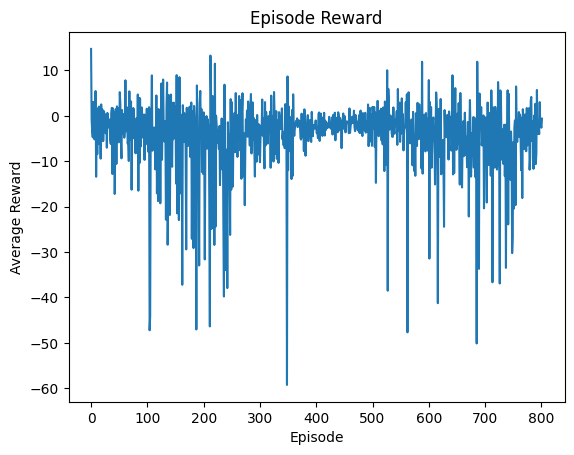

In [ ]:
# 에피소드별 누적 보상 그래프
plt.plot(callback.ep_rewards)
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.title("Episode Reward")
plt.show()

# 기간별 테스트

In [ ]:
# 종목 변경
ticker = 'TQQQ'

In [ ]:
test_data1 = get_data(ticker=ticker, start_date='2020-02-24', end_date='2021-01-01')

display(test_data1)

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,SMA_5,SMA_10,SMA_20
Ticker,TQQQ,TQQQ,TQQQ,TQQQ,,,
Date,,,,,,,
2020-02-24 00:00:00+00:00,23.92,24.90,23.41,24.07,27.56,27.89,26.48
2020-02-25 00:00:00+00:00,21.99,24.73,21.74,24.48,26.22,27.32,26.42
2020-02-26 00:00:00+00:00,22.29,23.43,21.79,22.32,24.78,26.77,26.33
2020-02-27 00:00:00+00:00,18.95,21.60,18.90,20.58,22.84,25.81,26.06
2020-02-28 00:00:00+00:00,19.25,19.36,16.88,17.10,21.28,24.89,25.79
...,...,...,...,...,...,...,...
2020-12-24 00:00:00+00:00,43.66,43.86,43.18,43.23,43.50,42.88,41.97
2020-12-28 00:00:00+00:00,44.97,45.19,44.01,44.79,43.78,43.34,42.26


In [ ]:
display(test_data1.head(20))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Price,Close,High,Low,Open,SMA_5,SMA_10,SMA_20
Ticker,TQQQ,TQQQ,TQQQ,TQQQ,,,
Date,,,,,,,
2020-02-24 00:00:00+00:00,23.92,24.90,23.41,24.07,27.56,27.89,26.48
2020-02-25 00:00:00+00:00,21.99,24.73,21.74,24.48,26.22,27.32,26.42
2020-02-26 00:00:00+00:00,22.29,23.43,21.79,22.32,24.78,26.77,26.33
2020-02-27 00:00:00+00:00,18.95,21.60,18.90,20.58,22.84,25.81,26.06
2020-02-28 00:00:00+00:00,19.25,19.36,16.88,17.10,21.28,24.89,25.79
2020-03-02 00:00:00+00:00,21.88,21.93,18.99,19.82,20.87,24.22,25.71
2020-03-03 00:00:00+00:00,19.82,22.88,19.22,22.09,20.44,23.33,25.48
2020-03-04 00:00:00+00:00,22.22,22.29,20.33,20.89,20.42,22.60,25.28


In [ ]:
# 테스트 환경
test_env1 = StockTradingEnv(data=test_data1, gamma=gamma, split=split, initial_funds=initial_funds, past_obs=past_obs)
test_env1.reset(seed=42)            # 환경의 시드 고정
test_env1.action_space.seed(42)     # 행동 공간 시드 고정
obs, info = test_env1.reset()

# 테스트
done = False
test_res = []

while not done:
    action, _ = ppo_model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = test_env1.step(action)
    done = done or truncated  # 'done' 상태를 'done'과 'truncated' 둘 다 고려하도록 설정

    # 테스트 결과 확인
    test_res.append({
        "Open": info["Open"],
        "High": info["High"],
        "Low": info["Low"],
        "Close": info["Close"],
        "Avg_Price": info["Avg_Price"],
        "평단 체결": info["Buy_Qty_Avg"],
        "매수 추천 가격": info["Buy_Price_Act"],
        "매수 추천 체결": info["Buy_Qty_Act"],
        "10% 수익 가격" : info["Sell_Price_Ten"],
        "10% 수익 체결": info["Sell_Qty_Ten"],
        "매도 추천 가격": info["Sell_Price_Act"],
        "매도 추천 체결": info["Sell_Qty_Act"],
        "쿼터 손절 수량": info["Sell_Qty_Quarter"],
        "보유 수량": info["Shares"],
        "예수금": info["Balance"],
        "자산": info["Portfolio_Value"],
        "수익률(%)": np.round((info["Portfolio_Value"] - initial_funds) / initial_funds * 100, 2),
        "DD(%)": np.round(info["DD"], 2),
        "쿼터 손절": info["Quarter_Loss"]
    })

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
test_df1 = pd.DataFrame(test_res)
test_df1.index = test_data1.index[past_obs:]
test_df1['보유 수량'] = test_df1['보유 수량'].astype(int)
display(test_df1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Open,High,Low,Close,Avg_Price,평단 체결,매수 추천 가격,매수 추천 체결,10% 수익 가격,10% 수익 체결,매도 추천 가격,매도 추천 체결,쿼터 손절 수량,보유 수량,예수금,자산,수익률(%),DD(%),쿼터 손절
Date,,,,,,,,,,,,,,,,,,,
2020-03-02 00:00:00+00:00,19.82,21.93,18.99,21.88,21.88,45.0,0.00,0.0,0.00,0.0,0.00,0.0,0,45,39014.97,39999.57,-0.00,0.00,
2020-03-03 00:00:00+00:00,22.09,22.88,19.22,19.82,20.79,25.0,22.01,25.0,24.07,0.0,22.02,0.0,0,95,38023.53,39906.43,-0.23,0.23,
2020-03-04 00:00:00+00:00,20.89,22.29,20.33,22.22,20.79,0.0,20.92,0.0,22.87,0.0,20.93,24.0,0,71,38556.58,40134.20,0.34,0.00,
2020-03-05 00:00:00+00:00,20.56,21.69,19.77,20.27,20.58,24.0,20.63,24.0,22.87,0.0,20.64,0.0,0,119,37583.20,39995.33,-0.01,0.35,
2020-03-06 00:00:00+00:00,18.18,19.52,17.75,19.21,20.16,26.0,21.13,26.0,22.64,0.0,21.14,0.0,0,171,36583.84,39868.75,-0.33,0.66,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24 00:00:00+00:00,43.23,43.86,43.18,43.66,41.68,0.0,43.88,11.0,45.62,0.0,43.89,0.0,0,114,46849.32,51826.56,29.57,0.10,
2020-12-28 00:00:00+00:00,44.79,45.19,44.01,44.97,41.68,0.0,44.10,0.0,45.85,0.0,44.11,29.0,0,85,48152.88,51975.33,29.94,0.00,
2020-12-29 00:00:00+00:00,45.59,45.85,44.70,45.10,41.68,0.0,44.10,0.0,45.85,63.0,44.11,22.0,0,0,52031.92,52031.92,30.08,0.00,


In [ ]:
print(f"수익률 : {test_df1.iloc[-1]['수익률(%)']}%")
print(f"MDD : {test_df1['DD(%)'].max()}%")

수익률 : 30.1%
MDD : 10.89%


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# # trade_log를 csv로 저장
# test_df1 = test_df1.reset_index()
# test_df1['Date'] = test_df1['Date'].dt.strftime('%Y-%m-%d')
# test_df1.to_csv('강화무매_2003_2012.csv', index=False)

# # scv를 구글 드라이브로 이동
# !cp /content/강화무매_2003_2012.csv /content/drive/MyDrive/

In [ ]:
# # 강화학습 모델 저장
# ppo_model.save("PPO_IBM_40split_reward20")

# # 구글 드라이브로 이동
# !cp PPO_IBM_40split_reward20.zip /content/drive/MyDrive/

In [ ]:
test_data2 = get_data(ticker=ticker, start_date='2017-12-22', end_date='2019-01-01')

# 테스트 환경
test_env2 = StockTradingEnv(data=test_data2, gamma=gamma, split=split, initial_funds=initial_funds, past_obs=past_obs)
test_env2.reset(seed=42)            # 환경의 시드 고정
test_env2.action_space.seed(42)     # 행동 공간 시드 고정
obs, info = test_env2.reset()

# 테스트
done = False
test_res = []

while not done:
    action, _ = ppo_model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = test_env2.step(action)
    done = done or truncated  # 'done' 상태를 'done'과 'truncated' 둘 다 고려하도록 설정

    # 테스트 결과 확인
    test_res.append({
        "Open": info["Open"],
        "High": info["High"],
        "Low": info["Low"],
        "Close": info["Close"],
        "Avg_Price": info["Avg_Price"],
        "평단 체결": info["Buy_Qty_Avg"],
        "매수 추천 가격": info["Buy_Price_Act"],
        "매수 추천 체결": info["Buy_Qty_Act"],
        "10% 수익 가격" : info["Sell_Price_Ten"],
        "10% 수익 체결": info["Sell_Qty_Ten"],
        "매도 추천 가격": info["Sell_Price_Act"],
        "매도 추천 체결": info["Sell_Qty_Act"],
        "쿼터 손절 수량": info["Sell_Qty_Quarter"],
        "보유 수량": info["Shares"],
        "예수금": info["Balance"],
        "자산": info["Portfolio_Value"],
        "수익률(%)": np.round((info["Portfolio_Value"] - initial_funds) / initial_funds * 100, 2),
        "DD(%)": np.round(info["DD"], 2),
        "쿼터 손절": info["Quarter_Loss"]
    })

test_df2 = pd.DataFrame(test_res)
test_df2.index = test_data2.index[past_obs:]
test_df2['보유 수량'] = test_df2['보유 수량'].astype(int)

print(f"수익률 : {test_df2.iloc[-1]['수익률(%)']}%")
print(f"MDD : {test_df2['DD(%)'].max()}%")

display(test_df2)

[*********************100%***********************]  1 of 1 completed


수익률 : -21.07%
MDD : 46.24%


,Open,High,Low,Close,Avg_Price,평단 체결,매수 추천 가격,매수 추천 체결,10% 수익 가격,10% 수익 체결,매도 추천 가격,매도 추천 체결,쿼터 손절 수량,보유 수량,예수금,자산,수익률(%),DD(%),쿼터 손절
Date,,,,,,,,,,,,,,,,,,,
2018-01-02 00:00:00+00:00,11.74,12.18,11.66,12.15,12.15,82.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,82,39003.26,39999.56,-0.00,0.00,
2018-01-03 00:00:00+00:00,12.20,12.56,12.20,12.51,12.15,0.0,12.21,0.0,13.37,0.0,12.22,21.0,0.0,61,39265.85,40028.96,0.07,0.00,
2018-01-04 00:00:00+00:00,12.66,12.70,12.54,12.58,12.15,0.0,12.26,0.0,13.37,0.0,12.27,16.0,0.0,45,39467.04,40033.14,0.08,0.00,
2018-01-05 00:00:00+00:00,12.76,12.99,12.69,12.96,12.15,0.0,12.32,0.0,13.37,0.0,12.33,12.0,0.0,33,39622.49,40050.17,0.13,0.00,
2018-01-08 00:00:00+00:00,12.96,13.13,12.95,13.11,12.15,0.0,12.53,0.0,13.37,0.0,12.54,9.0,0.0,24,39740.43,40055.07,0.14,0.00,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24 00:00:00+00:00,8.00,8.32,7.58,7.60,12.73,65.0,13.68,65.0,14.29,0.0,13.69,0.0,0.0,2713,6380.71,26999.51,-32.50,46.24,
2018-12-26 00:00:00+00:00,7.82,8.98,7.66,8.97,12.59,55.0,13.39,55.0,14.00,0.0,13.40,0.0,0.0,2823,5393.57,30715.88,-23.21,38.83,
2018-12-27 00:00:00+00:00,8.65,9.10,8.03,9.09,12.46,55.0,13.17,55.0,13.85,0.0,13.18,0.0,0.0,2933,4393.23,31054.20,-22.36,38.16,


In [ ]:
test_data3 = get_data(ticker=ticker, start_date='2018-12-24', end_date='2020-01-01')

# 테스트 환경
test_env3 = StockTradingEnv(data=test_data3, gamma=gamma, split=split, initial_funds=initial_funds, past_obs=past_obs)
test_env3.reset(seed=42)            # 환경의 시드 고정
test_env3.action_space.seed(42)     # 행동 공간 시드 고정
obs, info = test_env3.reset()

# 테스트
done = False
test_res = []

while not done:
    action, _ = ppo_model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = test_env3.step(action)
    done = done or truncated  # 'done' 상태를 'done'과 'truncated' 둘 다 고려하도록 설정

    # 테스트 결과 확인
    test_res.append({
        "Open": info["Open"],
        "High": info["High"],
        "Low": info["Low"],
        "Close": info["Close"],
        "Avg_Price": info["Avg_Price"],
        "평단 체결": info["Buy_Qty_Avg"],
        "매수 추천 가격": info["Buy_Price_Act"],
        "매수 추천 체결": info["Buy_Qty_Act"],
        "10% 수익 가격" : info["Sell_Price_Ten"],
        "10% 수익 체결": info["Sell_Qty_Ten"],
        "매도 추천 가격": info["Sell_Price_Act"],
        "매도 추천 체결": info["Sell_Qty_Act"],
        "쿼터 손절 수량": info["Sell_Qty_Quarter"],
        "보유 수량": info["Shares"],
        "예수금": info["Balance"],
        "자산": info["Portfolio_Value"],
        "수익률(%)": np.round((info["Portfolio_Value"] - initial_funds) / initial_funds * 100, 2),
        "DD(%)": np.round(info["DD"], 2),
        "쿼터 손절": info["Quarter_Loss"]
    })

test_df3 = pd.DataFrame(test_res)
test_df3.index = test_data3.index[past_obs:]
test_df3['보유 수량'] = test_df3['보유 수량'].astype(int)

print(f"수익률 : {test_df3.iloc[-1]['수익률(%)']}%")
print(f"MDD : {test_df3['DD(%)'].max()}%")

display(test_df3)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[*********************100%***********************]  1 of 1 completed


수익률 : 27.81%
MDD : 8.28%


,Open,High,Low,Close,Avg_Price,평단 체결,매수 추천 가격,매수 추천 체결,10% 수익 가격,10% 수익 체결,매도 추천 가격,매도 추천 체결,쿼터 손절 수량,보유 수량,예수금,자산,수익률(%),DD(%),쿼터 손절
Date,,,,,,,,,,,,,,,,,,,
2019-01-02 00:00:00+00:00,8.69,9.56,8.68,9.39,9.39,106.0,0.00,0.0,0.00,0.0,0.00,0.0,0,106,39004.22,39999.56,-0.00,0.00,
2019-01-03 00:00:00+00:00,8.99,9.10,8.41,8.48,8.92,58.0,9.37,58.0,10.33,0.0,9.38,0.0,0,222,38020.10,39902.66,-0.24,0.24,
2019-01-04 00:00:00+00:00,8.89,9.69,8.79,9.57,8.92,0.0,8.95,0.0,9.81,0.0,8.96,56.0,0,166,38555.78,40144.40,0.36,0.00,
2019-01-07 00:00:00+00:00,9.62,10.04,9.53,9.87,8.92,0.0,8.88,0.0,9.81,124.0,8.89,42.0,0,0,40186.04,40186.04,0.47,0.00,
2019-01-08 00:00:00+00:00,10.17,10.28,9.73,10.16,10.16,98.0,0.00,0.0,9.81,0.0,9.12,0.0,0,98,39189.92,40185.60,0.46,0.00,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24 00:00:00+00:00,21.49,21.52,21.31,21.46,20.99,0.0,22.12,23.0,23.00,0.0,22.13,0.0,0,164,47589.43,51108.87,27.77,0.00,
2019-12-26 00:00:00+00:00,21.56,22.03,21.56,22.02,21.11,0.0,22.20,22.0,23.09,0.0,22.21,0.0,0,186,47104.78,51200.50,28.00,0.00,
2019-12-27 00:00:00+00:00,22.25,22.26,21.79,21.95,21.20,0.0,22.33,22.0,23.22,0.0,22.34,0.0,0,208,46621.67,51187.27,27.97,0.03,


In [ ]:
test_data4 = get_data(ticker=ticker, start_date='2019-12-24', end_date='2021-01-01')

# 테스트 환경
test_env4 = StockTradingEnv(data=test_data4, gamma=gamma, split=split, initial_funds=initial_funds, past_obs=past_obs)
test_env4.reset(seed=42)            # 환경의 시드 고정
test_env4.action_space.seed(42)     # 행동 공간 시드 고정
obs, info = test_env4.reset()

# 테스트
done = False
test_res = []

while not done:
    action, _ = ppo_model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = test_env4.step(action)
    done = done or truncated  # 'done' 상태를 'done'과 'truncated' 둘 다 고려하도록 설정

    # 테스트 결과 확인
    test_res.append({
        "Open": info["Open"],
        "High": info["High"],
        "Low": info["Low"],
        "Close": info["Close"],
        "Avg_Price": info["Avg_Price"],
        "평단 체결": info["Buy_Qty_Avg"],
        "매수 추천 가격": info["Buy_Price_Act"],
        "매수 추천 체결": info["Buy_Qty_Act"],
        "10% 수익 가격" : info["Sell_Price_Ten"],
        "10% 수익 체결": info["Sell_Qty_Ten"],
        "매도 추천 가격": info["Sell_Price_Act"],
        "매도 추천 체결": info["Sell_Qty_Act"],
        "쿼터 손절 수량": info["Sell_Qty_Quarter"],
        "보유 수량": info["Shares"],
        "예수금": info["Balance"],
        "자산": info["Portfolio_Value"],
        "수익률(%)": np.round((info["Portfolio_Value"] - initial_funds) / initial_funds * 100, 2),
        "DD(%)": np.round(info["DD"], 2),
        "쿼터 손절": info["Quarter_Loss"]
    })

test_df4 = pd.DataFrame(test_res)
test_df4.index = test_data4.index[past_obs:]
test_df4['보유 수량'] = test_df4['보유 수량'].astype(int)

print(f"수익률 : {test_df4.iloc[-1]['수익률(%)']}%")
print(f"MDD : {test_df4['DD(%)'].max()}%")

display(test_df4)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[*********************100%***********************]  1 of 1 completed


수익률 : 37.87%
MDD : 28.17%


,Open,High,Low,Close,Avg_Price,평단 체결,매수 추천 가격,매수 추천 체결,10% 수익 가격,10% 수익 체결,매도 추천 가격,매도 추천 체결,쿼터 손절 수량,보유 수량,예수금,자산,수익률(%),DD(%),쿼터 손절
Date,,,,,,,,,,,,,,,,,,,
2020-01-02 00:00:00+00:00,22.18,22.71,22.06,22.71,22.71,44.0,0.00,0.0,0.00,0.0,0.00,0.0,0,44,39000.32,39999.56,-0.00,0.00,
2020-01-03 00:00:00+00:00,21.82,22.50,21.81,22.09,22.40,22.0,22.90,22.0,24.98,0.0,22.91,0.0,0,88,38027.94,39971.86,-0.07,0.07,
2020-01-06 00:00:00+00:00,21.57,22.52,21.49,22.51,22.42,0.0,22.60,22.0,24.64,0.0,22.61,0.0,0,110,37532.50,40008.60,0.02,0.00,
2020-01-07 00:00:00+00:00,22.53,22.69,22.29,22.49,22.43,0.0,22.81,22.0,24.66,0.0,22.82,0.0,0,132,37037.50,40006.18,0.02,0.01,
2020-01-08 00:00:00+00:00,22.49,23.32,22.38,23.00,22.51,0.0,23.22,21.0,24.67,0.0,23.23,0.0,0,153,36554.29,40073.29,0.18,0.00,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24 00:00:00+00:00,43.23,43.86,43.18,43.66,41.68,0.0,43.88,11.0,45.62,0.0,43.89,0.0,0,114,49959.99,54937.23,37.34,0.10,
2020-12-28 00:00:00+00:00,44.79,45.19,44.01,44.97,41.68,0.0,44.10,0.0,45.85,0.0,44.11,29.0,0,85,51263.55,55086.00,37.71,0.00,
2020-12-29 00:00:00+00:00,45.59,45.85,44.70,45.10,41.68,0.0,44.10,0.0,45.85,63.0,44.11,22.0,0,0,55142.59,55142.59,37.86,0.00,


In [ ]:
test_data5 = get_data(ticker=ticker, start_date='2020-12-24', end_date='2022-01-01')

# 테스트 환경
test_env5 = StockTradingEnv(data=test_data5, gamma=gamma, split=split, initial_funds=initial_funds, past_obs=past_obs)
test_env5.reset(seed=42)            # 환경의 시드 고정
test_env5.action_space.seed(42)     # 행동 공간 시드 고정
obs, info = test_env5.reset()

# 테스트
done = False
test_res = []

while not done:
    action, _ = ppo_model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = test_env5.step(action)
    done = done or truncated  # 'done' 상태를 'done'과 'truncated' 둘 다 고려하도록 설정

    # 테스트 결과 확인
    test_res.append({
        "Open": info["Open"],
        "High": info["High"],
        "Low": info["Low"],
        "Close": info["Close"],
        "Avg_Price": info["Avg_Price"],
        "평단 체결": info["Buy_Qty_Avg"],
        "매수 추천 가격": info["Buy_Price_Act"],
        "매수 추천 체결": info["Buy_Qty_Act"],
        "10% 수익 가격" : info["Sell_Price_Ten"],
        "10% 수익 체결": info["Sell_Qty_Ten"],
        "매도 추천 가격": info["Sell_Price_Act"],
        "매도 추천 체결": info["Sell_Qty_Act"],
        "쿼터 손절 수량": info["Sell_Qty_Quarter"],
        "보유 수량": info["Shares"],
        "예수금": info["Balance"],
        "자산": info["Portfolio_Value"],
        "수익률(%)": np.round((info["Portfolio_Value"] - initial_funds) / initial_funds * 100, 2),
        "DD(%)": np.round(info["DD"], 2),
        "쿼터 손절": info["Quarter_Loss"]
    })

test_df5 = pd.DataFrame(test_res)
test_df5.index = test_data5.index[past_obs:]
test_df5['보유 수량'] = test_df5['보유 수량'].astype(int)

print(f"수익률 : {test_df5.iloc[-1]['수익률(%)']}%")
print(f"MDD : {test_df5['DD(%)'].max()}%")

display(test_df5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[*********************100%***********************]  1 of 1 completed


수익률 : 33.79%
MDD : 7.25%


,Open,High,Low,Close,Avg_Price,평단 체결,매수 추천 가격,매수 추천 체결,10% 수익 가격,10% 수익 체결,매도 추천 가격,매도 추천 체결,쿼터 손절 수량,보유 수량,예수금,자산,수익률(%),DD(%),쿼터 손절
Date,,,,,,,,,,,,,,,,,,,
2021-01-04 00:00:00+00:00,46.02,46.10,41.71,43.46,43.46,23.0,0.00,0.0,0.00,0.0,0.00,0.0,0,23,38999.98,39999.56,-0.00,0.00,
2021-01-05 00:00:00+00:00,43.07,44.64,43.07,44.55,43.46,0.0,43.54,0.0,47.81,0.0,43.55,6.0,0,17,39267.16,40024.51,0.06,0.00,
2021-01-06 00:00:00+00:00,42.47,44.58,42.06,42.71,43.04,11.0,43.75,11.0,47.81,0.0,43.76,0.0,0,39,38327.12,39992.81,-0.02,0.08,
2021-01-07 00:00:00+00:00,43.84,46.16,43.84,45.79,43.04,0.0,43.74,0.0,47.34,0.0,43.75,10.0,0,29,38784.82,40112.73,0.28,0.00,
2021-01-08 00:00:00+00:00,46.83,47.72,45.85,47.57,43.04,0.0,44.58,0.0,47.34,21.0,44.59,8.0,0,0,40158.91,40158.91,0.40,0.00,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27 00:00:00+00:00,83.54,86.76,83.50,86.69,79.59,0.0,84.22,0.0,87.55,0.0,84.23,55.0,0,164,39666.26,53883.42,34.71,0.00,
2021-12-28 00:00:00+00:00,87.38,87.49,85.01,85.68,79.59,0.0,84.22,0.0,87.55,0.0,84.23,41.0,0,123,43177.59,53716.23,34.29,0.31,
2021-12-29 00:00:00+00:00,85.65,86.50,83.97,85.54,79.59,0.0,84.22,0.0,87.55,0.0,84.23,31.0,0,92,45828.16,53697.84,34.24,0.34,


In [ ]:
test_data6 = get_data(ticker=ticker, start_date='2021-12-27', end_date='2023-01-01')

# 테스트 환경
test_env6 = StockTradingEnv(data=test_data6, gamma=gamma, split=split, initial_funds=initial_funds, past_obs=past_obs)
test_env6.reset(seed=42)            # 환경의 시드 고정
test_env6.action_space.seed(42)     # 행동 공간 시드 고정
obs, info = test_env6.reset()

# 테스트
done = False
test_res = []

while not done:
    action, _ = ppo_model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = test_env6.step(action)
    done = done or truncated  # 'done' 상태를 'done'과 'truncated' 둘 다 고려하도록 설정

    # 테스트 결과 확인
    test_res.append({
        "Open": info["Open"],
        "High": info["High"],
        "Low": info["Low"],
        "Close": info["Close"],
        "Avg_Price": info["Avg_Price"],
        "평단 체결": info["Buy_Qty_Avg"],
        "매수 추천 가격": info["Buy_Price_Act"],
        "매수 추천 체결": info["Buy_Qty_Act"],
        "10% 수익 가격" : info["Sell_Price_Ten"],
        "10% 수익 체결": info["Sell_Qty_Ten"],
        "매도 추천 가격": info["Sell_Price_Act"],
        "매도 추천 체결": info["Sell_Qty_Act"],
        "쿼터 손절 수량": info["Sell_Qty_Quarter"],
        "보유 수량": info["Shares"],
        "예수금": info["Balance"],
        "자산": info["Portfolio_Value"],
        "수익률(%)": np.round((info["Portfolio_Value"] - initial_funds) / initial_funds * 100, 2),
        "DD(%)": np.round(info["DD"], 2),
        "쿼터 손절": info["Quarter_Loss"]
    })

test_df6 = pd.DataFrame(test_res)
test_df6.index = test_data6.index[past_obs:]
test_df6['보유 수량'] = test_df6['보유 수량'].astype(int)

print(f"수익률 : {test_df6.iloc[-1]['수익률(%)']}%")
print(f"MDD : {test_df6['DD(%)'].max()}%")

display(test_df6)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[*********************100%***********************]  1 of 1 completed


수익률 : -17.17%
MDD : 38.86%


,Open,High,Low,Close,Avg_Price,평단 체결,매수 추천 가격,매수 추천 체결,10% 수익 가격,10% 수익 체결,매도 추천 가격,매도 추천 체결,쿼터 손절 수량,보유 수량,예수금,자산,수익률(%),DD(%),쿼터 손절
Date,,,,,,,,,,,,,,,,,,,
2022-01-03 00:00:00+00:00,83.92,85.72,82.56,85.57,85.57,11.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,11,39058.32,39999.59,-0.00,0.00,
2022-01-04 00:00:00+00:00,85.92,85.94,80.19,82.24,83.83,6.0,85.82,6.0,94.13,0.0,85.83,0.0,0.0,23,38071.00,39962.52,-0.09,0.09,
2022-01-05 00:00:00+00:00,81.19,81.86,74.50,74.68,80.70,6.0,84.55,6.0,92.21,0.0,84.56,0.0,0.0,35,37174.44,39788.24,-0.53,0.53,
2022-01-06 00:00:00+00:00,73.51,76.40,72.21,74.47,79.11,6.0,82.26,6.0,88.77,0.0,82.27,0.0,0.0,47,36280.40,39780.49,-0.55,0.55,
2022-01-07 00:00:00+00:00,74.45,75.47,71.00,72.04,77.67,6.0,81.93,6.0,87.02,0.0,81.94,0.0,0.0,59,35415.54,39665.90,-0.84,0.84,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23 00:00:00+00:00,17.21,17.72,16.83,17.59,19.69,28.0,21.05,28.0,21.89,0.0,21.06,0.0,0.0,604,22587.93,33212.29,-16.97,19.47,
2022-12-27 00:00:00+00:00,17.46,17.48,16.72,16.84,19.44,29.0,20.83,29.0,21.66,0.0,20.84,0.0,0.0,662,21610.79,32758.87,-18.10,20.57,
2022-12-28 00:00:00+00:00,16.75,17.20,16.10,16.16,19.17,30.0,20.56,30.0,21.38,0.0,20.57,0.0,0.0,722,20640.77,32308.29,-19.23,21.67,


In [ ]:
test_data7 = get_data(ticker=ticker, start_date='2022-12-26', end_date='2024-01-01')

# 테스트 환경
test_env7 = StockTradingEnv(data=test_data7, gamma=gamma, split=split, initial_funds=initial_funds, past_obs=past_obs)
test_env7.reset(seed=42)            # 환경의 시드 고정
test_env7.action_space.seed(42)     # 행동 공간 시드 고정
obs, info = test_env7.reset()

# 테스트
done = False
test_res = []

while not done:
    action, _ = ppo_model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = test_env7.step(action)
    done = done or truncated  # 'done' 상태를 'done'과 'truncated' 둘 다 고려하도록 설정

    # 테스트 결과 확인
    test_res.append({
        "Open": info["Open"],
        "High": info["High"],
        "Low": info["Low"],
        "Close": info["Close"],
        "Avg_Price": info["Avg_Price"],
        "평단 체결": info["Buy_Qty_Avg"],
        "매수 추천 가격": info["Buy_Price_Act"],
        "매수 추천 체결": info["Buy_Qty_Act"],
        "10% 수익 가격" : info["Sell_Price_Ten"],
        "10% 수익 체결": info["Sell_Qty_Ten"],
        "매도 추천 가격": info["Sell_Price_Act"],
        "매도 추천 체결": info["Sell_Qty_Act"],
        "쿼터 손절 수량": info["Sell_Qty_Quarter"],
        "보유 수량": info["Shares"],
        "예수금": info["Balance"],
        "자산": info["Portfolio_Value"],
        "수익률(%)": np.round((info["Portfolio_Value"] - initial_funds) / initial_funds * 100, 2),
        "DD(%)": np.round(info["DD"], 2),
        "쿼터 손절": info["Quarter_Loss"]
    })

test_df7 = pd.DataFrame(test_res)
test_df7.index = test_data7.index[past_obs:]
test_df7['보유 수량'] = test_df7['보유 수량'].astype(int)

print(f"수익률 : {test_df7.iloc[-1]['수익률(%)']}%")
print(f"MDD : {test_df7['DD(%)'].max()}%")

display(test_df7)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[*********************100%***********************]  1 of 1 completed


수익률 : 23.3%
MDD : 23.41%


,Open,High,Low,Close,Avg_Price,평단 체결,매수 추천 가격,매수 추천 체결,10% 수익 가격,10% 수익 체결,매도 추천 가격,매도 추천 체결,쿼터 손절 수량,보유 수량,예수금,자산,수익률(%),DD(%),쿼터 손절
Date,,,,,,,,,,,,,,,,,,,
2023-01-04 00:00:00+00:00,17.33,17.49,16.54,17.17,17.17,58.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,58,39003.70,39999.56,-0.00,0.00,
2023-01-05 00:00:00+00:00,16.81,16.85,16.28,16.36,16.76,30.0,17.15,30.0,18.89,0.0,17.16,0.0,0.0,118,38021.66,39952.14,-0.12,0.12,
2023-01-06 00:00:00+00:00,16.65,17.90,16.10,17.64,16.76,0.0,16.86,0.0,18.44,0.0,16.87,30.0,0.0,88,38550.63,40102.95,0.26,0.00,
2023-01-09 00:00:00+00:00,18.08,18.96,17.89,18.01,16.76,0.0,16.66,0.0,18.44,66.0,16.67,22.0,0.0,0,40163.18,40163.18,0.41,0.00,
2023-01-10 00:00:00+00:00,17.82,18.49,17.70,18.49,18.49,54.0,0.00,0.0,18.44,0.0,17.23,0.0,0.0,54,39164.28,40162.74,0.41,0.00,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22 00:00:00+00:00,50.60,50.94,49.64,50.35,49.45,0.0,52.21,9.0,54.27,0.0,52.22,0.0,0.0,86,44981.40,49311.50,23.28,0.00,
2023-12-26 00:00:00+00:00,50.64,51.51,50.62,51.27,49.62,0.0,52.32,9.0,54.40,0.0,52.33,0.0,0.0,95,44519.77,49390.42,23.48,0.00,
2023-12-27 00:00:00+00:00,51.35,51.66,51.02,51.54,49.79,0.0,52.50,9.0,54.58,0.0,52.51,0.0,0.0,104,44055.71,49415.87,23.54,0.00,


In [ ]:
test_data = get_data(ticker=ticker, start_date='2019-12-24', end_date='2024-01-01')

# 테스트 환경
test_env = StockTradingEnv(data=test_data, gamma=gamma, split=split, initial_funds=initial_funds, past_obs=past_obs)
test_env.reset(seed=42)            # 환경의 시드 고정
test_env.action_space.seed(42)     # 행동 공간 시드 고정
obs, info = test_env.reset()

# 테스트
done = False
test_res = []

while not done:
    action, _ = ppo_model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = test_env.step(action)
    done = done or truncated  # 'done' 상태를 'done'과 'truncated' 둘 다 고려하도록 설정

    # 테스트 결과 확인
    test_res.append({
        "Open": info["Open"],
        "High": info["High"],
        "Low": info["Low"],
        "Close": info["Close"],
        "Avg_Price": info["Avg_Price"],
        "평단 체결": info["Buy_Qty_Avg"],
        "매수 추천 가격": info["Buy_Price_Act"],
        "매수 추천 체결": info["Buy_Qty_Act"],
        "10% 수익 가격" : info["Sell_Price_Ten"],
        "10% 수익 체결": info["Sell_Qty_Ten"],
        "매도 추천 가격": info["Sell_Price_Act"],
        "매도 추천 체결": info["Sell_Qty_Act"],
        "쿼터 손절 수량": info["Sell_Qty_Quarter"],
        "보유 수량": info["Shares"],
        "예수금": info["Balance"],
        "자산": info["Portfolio_Value"],
        "수익률(%)": np.round((info["Portfolio_Value"] - initial_funds) / initial_funds * 100, 2),
        "DD(%)": np.round(info["DD"], 2),
        "쿼터 손절": info["Quarter_Loss"]
    })

test_df = pd.DataFrame(test_res)
test_df.index = test_data.index[past_obs:]
test_df['보유 수량'] = test_df['보유 수량'].astype(int)

print(f"수익률 : {test_df.iloc[-1]['수익률(%)']}%")
print(f"MDD : {test_df['DD(%)'].max()}%")

display(test_df)

[*********************100%***********************]  1 of 1 completed


수익률 : 144.81%
MDD : 28.17%


,Open,High,Low,Close,Avg_Price,평단 체결,매수 추천 가격,매수 추천 체결,10% 수익 가격,10% 수익 체결,매도 추천 가격,매도 추천 체결,쿼터 손절 수량,보유 수량,예수금,자산,수익률(%),DD(%),쿼터 손절
Date,,,,,,,,,,,,,,,,,,,
2020-01-02 00:00:00+00:00,22.18,22.71,22.06,22.71,22.71,44.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,44,39000.32,39999.56,-0.00,0.00,
2020-01-03 00:00:00+00:00,21.82,22.50,21.81,22.09,22.40,22.0,22.90,22.0,24.98,0.0,22.91,0.0,0.0,88,38027.94,39971.86,-0.07,0.07,
2020-01-06 00:00:00+00:00,21.57,22.52,21.49,22.51,22.42,0.0,22.60,22.0,24.64,0.0,22.61,0.0,0.0,110,37532.50,40008.60,0.02,0.00,
2020-01-07 00:00:00+00:00,22.53,22.69,22.29,22.49,22.43,0.0,22.81,22.0,24.66,0.0,22.82,0.0,0.0,132,37037.50,40006.18,0.02,0.01,
2020-01-08 00:00:00+00:00,22.49,23.32,22.38,23.00,22.51,0.0,23.22,21.0,24.67,0.0,23.23,0.0,0.0,153,36554.29,40073.29,0.18,0.00,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22 00:00:00+00:00,50.60,50.94,49.64,50.35,49.45,0.0,52.21,9.0,54.27,0.0,52.22,0.0,0.0,86,93585.36,97915.46,144.79,0.00,
2023-12-26 00:00:00+00:00,50.64,51.51,50.62,51.27,49.62,0.0,52.32,9.0,54.40,0.0,52.33,0.0,0.0,95,93123.73,97994.38,144.99,0.00,
2023-12-27 00:00:00+00:00,51.35,51.66,51.02,51.54,49.79,0.0,52.50,9.0,54.58,0.0,52.51,0.0,0.0,104,92659.67,98019.83,145.05,0.00,


In [ ]:
print("2020-03-01 ~ 2020-12-31 (상승장)")
print(f"수익률 : {test_df1.iloc[-1]['수익률(%)']}%")
print(f"MDD : {test_df1['DD(%)'].max()}%")

print("\n2018-01-01 ~ 2018-12-31")
print(f"수익률 : {test_df2.iloc[-1]['수익률(%)']}%")
print(f"MDD : {test_df2['DD(%)'].max()}%")

print("\n2019-01-01 ~ 2019-12-31")
print(f"수익률 : {test_df3.iloc[-1]['수익률(%)']}%")
print(f"MDD : {test_df3['DD(%)'].max()}%")

print("\n2020-01-01 ~ 2020-12-31")
print(f"수익률 : {test_df4.iloc[-1]['수익률(%)']}%")
print(f"MDD : {test_df4['DD(%)'].max()}%")

print("\n2021-01-01 ~ 2021-12-31")
print(f"수익률 : {test_df5.iloc[-1]['수익률(%)']}%")
print(f"MDD : {test_df5['DD(%)'].max()}%")

print("\n2022-01-01 ~ 2022-12-31")
print(f"수익률 : {test_df6.iloc[-1]['수익률(%)']}%")
print(f"MDD : {test_df6['DD(%)'].max()}%")

print("\n2023-01-01 ~ 2023-12-31")
print(f"수익률 : {test_df7.iloc[-1]['수익률(%)']}%")
print(f"MDD : {test_df7['DD(%)'].max()}%")

print("\n2020-01-01 ~ 2023-12-31")
print(f"수익률 : {test_df.iloc[-1]['수익률(%)']}%")
print(f"MDD : {test_df['DD(%)'].max()}%")

2020-03-01 ~ 2020-12-31 (상승장)
수익률 : 30.1%
MDD : 10.89%

2018-01-01 ~ 2018-12-31
수익률 : -21.07%
MDD : 46.24%

2019-01-01 ~ 2019-12-31
수익률 : 27.81%
MDD : 8.28%

2020-01-01 ~ 2020-12-31
수익률 : 37.87%
MDD : 28.17%

2021-01-01 ~ 2021-12-31
수익률 : 33.79%
MDD : 7.25%

2022-01-01 ~ 2022-12-31
수익률 : -17.17%
MDD : 38.86%

2023-01-01 ~ 2023-12-31
수익률 : 23.3%
MDD : 23.41%

2020-01-01 ~ 2023-12-31
수익률 : 144.81%
MDD : 28.17%


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# # trade_log를 csv로 저장
# test_df = test_df.reset_index()
# test_df['Date'] = test_df['Date'].dt.strftime('%Y-%m-%d')
# test_df.to_csv('강화무매.csv', index=False)

# # scv를 구글 드라이브로 이동
# !cp /content/강화무매.csv /content/drive/MyDrive/

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# # 강화학습 모델 저장
# ppo_model.save("PPO_IBM")

# # 구글 드라이브로 이동
# !cp PPO_IBM.zip /content/drive/MyDrive/

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
